## De module `GeoPandas`

[GeoPandas](https://geopandas.org/en/stable/) is een open source-project om het werken met ruimtelijke gegevens in python gemakkelijker te maken. GeoPandas breidt de datatypes uit die door pandas worden gebruikt om ruimtelijke bewerkingen op geometrische types mogelijk te maken. Geometrische bewerkingen worden uitgevoerd door [shapely](https://shapely.readthedocs.io/en/stable/index.html). GeoPandas is verder afhankelijk van [fiona](https://pypi.org/project/Fiona/) voor bestandstoegang en [matplotlib](https://matplotlib.org/) voor plotten.

[Hier](https://geopandas.org/getting_started/introduction.html) vind je een uitgebreide GeoPandas introductie en voorbeeldscripts.

Om het GeoPandas te kunnen werken, beginnen we met het importeren van de noodzakelijke modules.

In [1]:
# Import modules
# LET OP: 
# Installeer eerst Fiona en RTREE van https://www.lfd.uci.edu/~gohlke/pythonlibs/
# Dan geopandas installeren
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# Set current dir as working dir

os.chdir(os.getcwd())
print('Working directory is ' + str(os.getcwd()))

Working directory is c:\git_repositories\Quatro-Book-TeM


In dit voorbeeld gaan we achtereenvolgens:
- Een csv-bestand *world_earthquakes.csv* met de locatie en magnitude van aardbevingen inlezen
- De aardbevingen plotten op een wereldkaart
- Via een spatial join alleen de aardbevingen selecteren die op land hebben plaatsgevonden
- Resultaat opslaan in Geojson file

We beginnen met het inlezen van het csv-bestand waarbij alle rijen die geen coördinaten en/of magnitude hebben (kolommen *latitude* en/of *longitude* en/of *eq_primary* zijn leeg) niet ingelezen worden.

In [2]:
# Import world earthquales csv into dataframe and drop rows without latitude and longitude
df = pd.read_csv('data_files/world_earthquakes.csv',sep=',').dropna(subset=["LATITUDE", "LONGITUDE","EQ_PRIMARY"])

# Printing column names (when first row is not skipped and first 5 rows)
print(df.columns.values)
print(df[['COUNTRY', 'EQ_PRIMARY','LATITUDE', 'LONGITUDE']].head(5))

['I_D' 'FLAG_TSUNAMI' 'YEAR' 'MONTH' 'DAY' 'HOUR' 'MINUTE' 'SECOND'
 'FOCAL_DEPTH' 'EQ_PRIMARY' 'EQ_MAG_MW' 'EQ_MAG_MS' 'EQ_MAG_MB'
 'EQ_MAG_ML' 'EQ_MAG_MFA' 'EQ_MAG_UNK' 'INTENSITY' 'COUNTRY' 'STATE'
 'LOCATION_NAME' 'LATITUDE' 'LONGITUDE' 'REGION_CODE' 'DEATHS'
 'DEATHS_DESCRIPTION' 'MISSING' 'MISSING_DESCRIPTION' 'INJURIES'
 'INJURIES_DESCRIPTION' 'DAMAGE_MILLIONS_DOLLARS' 'DAMAGE_DESCRIPTION'
 'HOUSES_DESTROYED' 'HOUSES_DESTROYED_DESCRIPTION' 'HOUSES_DAMAGED'
 'HOUSES_DAMAGED_DESCRIPTION' 'TOTAL_DEATHS' 'TOTAL_DEATHS_DESCRIPTION'
 'TOTAL_MISSING' 'TOTAL_MISSING_DESCRIPTION' 'TOTAL_INJURIES'
 'TOTAL_INJURIES_DESCRIPTION' 'TOTAL_DAMAGE_MILLIONS_DOLLARS'
 'TOTAL_DAMAGE_DESCRIPTION' 'TOTAL_HOUSES_DESTROYED'
 'TOTAL_HOUSES_DESTROYED_DESCRIPTION' 'TOTAL_HOUSES_DAMAGED'
 'TOTAL_HOUSES_DAMAGED_DESCRIPTION' 'field_48' 'field_49' 'field_50'
 'field_51' 'field_52']
         COUNTRY  EQ_PRIMARY  LATITUDE  LONGITUDE
0   TURKMENISTAN         7.1      38.0       58.2
6         ISRAEL         6.5 

In de volgende stap maken we een geodataframe van het dataframe met het csv-bestand. Er wordt een extra kolom aan het dataframe toegoevoegd waarin de coördinaat van de aardbeving opgeslagen wordt. Deze coördinaat wordt gemaakt op basis van de x-waarde in de kolom *longitude* en de y-waarde in de kolom *latitude* met de functie [points_from_xy](https://geopandas.org/en/stable/docs/reference/api/geopandas.points_from_xy.html). Bij de parameter *crs* moet het coördinaatsysteem van de coördinaten opgegeven worden. In dit geval [WGS84](https://epsg.io/4326) met EPSG:4326.

In [3]:
# Make geodata frame
gdf_earthquakes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['LONGITUDE'],df['LATITUDE']),crs='EPSG:4326')

# Print first 5 geometries (as WKT)
print(gdf_earthquakes['geometry'].head(5))

0     POINT (58.20000 38.00000)
6     POINT (35.50000 32.00000)
7     POINT (35.00000 29.60000)
12    POINT (23.30000 39.70000)
14    POINT (22.70000 38.90000)
Name: geometry, dtype: geometry


Om te controleren of de aardbevingen goed ingeladen zijn, gaan we deze plotten op een wereldkaart. We gebruiken de dataset *naturalearth_lowres* als achtergrondkaart. De kaart wordt meegeleverd met de installatie van GeoPandas.

Use c:\Software\Python311\Lib\site-packages\geopandas\datasets\naturalearth_lowres\naturalearth_lowres.shp as world map


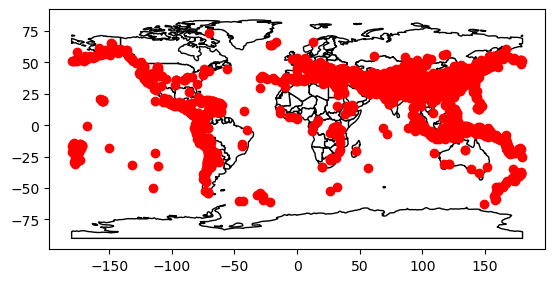

In [4]:
# Import world map
print('Use ' + str(gpd.datasets.get_path("naturalearth_lowres")) + ' as world map')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set color and edgecolor
ax = world.plot(color='white', edgecolor='black')

# We can now plot our GeoDataFrame with earthquakes in red
gdf_earthquakes.plot(ax=ax, color='red')

# Show map
plt.show()

We willen gaan tellen hoeveel aardbeving op land hebben plaatsgevonden. We gaan dit doen door middel van een spatial query waarbij we alleen de aardbevingen selecteren die binnen een grenzen (polygoon) van een land vallen. We beginnen met het importeren van de dataset *UIA_World_Countries_Boundaries.shp* voor de polygonen van de landen en printen ter controle de kolommen en de eerste polygoon.

In [5]:
# Import world shapefile
gdf_countries = gpd.read_file("data_files/UIA_World_Countries_Boundaries.shp")
print(gdf_countries.columns.values)
print(gdf_countries['geometry'].head(1))

['FID' 'Country' 'ISO' 'COUNTRYAFF' 'AFF_ISO' 'geometry']
0    MULTIPOLYGON (((-59.34806 -52.34305, -59.37945...
Name: geometry, dtype: geometry


Nu kunnen we de spatial join uitvoeren. Check hiervoor eerst of beide datasets dezelfde coördinaatsystemen hebben. Als dit niet het geval is moet je de functie [to_crs](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) gebruiken om te zorgen dat beide geodataframes hetzelfde coördinaatsysteem hebben. 

Daarna voeren we de spatial join uit met de functie [sjoin](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html). We voeren een inner join uit zodat alleen de rijen overblijven met aardbevingen die binnen een landpolygoon vallen. Als laatste worden het totaal aantal aardbevingen in het geodataframe en het aantal aardbevingen op land geprint.

In [6]:
# Check coördinate systems
print('Coordinate system earthquakes: ' + str(gdf_earthquakes.crs))
print('Coordinate system countries: ' + str(gdf_countries.crs))

# Spatial join
if gdf_earthquakes.crs == gdf_countries.crs:
    join_inner_df = gpd.sjoin(gdf_earthquakes, gdf_countries, how='inner')
else:
    print('Different coordinate systems, cannot perform spatial join')

# Print results
print('Total number of earthquakes: ' + str(len(gdf_earthquakes)))
print('Total number of earthquakes on land: ' + str(len(join_inner_df)))

Coordinate system earthquakes: EPSG:4326
Coordinate system countries: epsg:4326
Total number of earthquakes: 3169
Total number of earthquakes on land: 1930


We willen alleen de kolommen *COUNTRY*, *LOCATION_NAME*, *EQ_PRIMARY* en *geometry* opslaan in een Geojson. Ook de rijen zonder magnitude willen we niet meenemen.

In [7]:
# Make new dataframe with 4 columns only (select columns)
gdf_new = join_inner_df[['COUNTRY', 'LOCATION_NAME', 'EQ_PRIMARY','geometry']]

# Select only rows with magnitude
gdf_cleaned = gdf_new[gdf_new['EQ_PRIMARY'].notna()]
print(gdf_cleaned.head(5))

# Export to geojson
gdf_new.to_file("data_files/world_earthquakes.json", driver="GeoJSON")

          COUNTRY              LOCATION_NAME  EQ_PRIMARY  \
0    TURKMENISTAN           TURKMENISTAN:  W         7.1   
42   TURKMENISTAN        TURKMENISTAN:  NISA         7.1   
227  TURKMENISTAN        TURKMENISTAN:  NISA         7.1   
301  TURKMENISTAN               TURKMENISTAN         7.1   
312  TURKMENISTAN  TURKMENISTAN:  GURGANDZHE         6.1   

                      geometry  
0    POINT (58.20000 38.00000)  
42   POINT (58.30000 38.00000)  
227  POINT (58.30000 38.00000)  
301  POINT (65.50000 37.50000)  
312  POINT (60.00000 42.00000)  


c:\Software\Python311\Lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
